In [1]:
import os, sys
import pickle 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
sys.path.insert(0,'../../LongTermEMG-master')

# 0. Prepare Data
* 20 participants total (exclude 10 and 11)
* data from 3DC armband (10 channels with 1000 Hz)
* 150 ms frames with overlap of 100 ms; band-pass filter between 20-495 Hz using fourth-order butterworth filter
* dataset dict
    * examples_training
    * labels_training
    * training_datetimes
    * highest_activations
    * examples_evaluation
    * labels_evaluation
    * evaluation_emg_timestamps
    * angles_and_timestamps
    * evaluation_datetimes
* feature_set_function = feature_extraction.getTSD applied to each window 
    * exclude 0 sEMG recordings 
    * [1] A. Al-Timemy, R. N. Khushaba, G. Bugmann, and J. Escudero, "Improving the Performance Against Force Variation of EMG Controlled Multifunctional Upper-Limb Prostheses for Transradial Amputees", IEEE Transactions on Neural Systems and Rehabilitation Engineering, DOI: 10.1109/TNSRE.2015.2445634, 2015.
    * [2] R. N. Khushaba, Maen Takruri, Jaime Valls Miro, and Sarath Kodagoda, "Towards limb position invariant myoelectric pattern recognition using time-dependent spectral features", Neural Networks, vol. 55, pp. 42-58, 2014.

In [2]:
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.prepare_dataset_utils import butter_bandpass_filter, \
    show_filtered_signal, load_timestamps_from_participant, get_angles_from_positions_3d_arm
from LongTermClassificationMain.PrepareAndLoadDataLongTerm import feature_extraction

In [3]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/PrepareAndLoadDataLongTerm")
print(os.listdir("../../"))
from handcrafted_features_prepare_from_from_raw_dataset import read_data_training

['longterm_dataset_3DC.zip', 'longterm_dataset_3DC', 'README.md', 'LongTermClassificationMain', 'datasets', 'TransferLearning', '.idea', 'Weights_TSD']


In [4]:
list_participant_training_1_to_skip = ["Participant0/Training1", "Participant0/Evaluation2", "Participant0/Evaluation3",
                                       "Participant2/Training1", "Participant2/Evaluation2", "Participant2/Evaluation3"]

In [5]:
# features_set_name = "TSD_features_set"
# feature_set_function = feature_extraction.getTSD
# read_data_training(path="../../datasets/longterm_dataset_3DC", features_set_name=features_set_name, \
#                 feature_set_function=feature_set_function)

# 1. Temporal-Spatial Descriptors Deep Network (TSD_DNN)
* input size = 128 x 3 x 1 = 384
* 3 fully connected layers with 200 neurons 
    * batch normalization
    * leaky ReLU (0.1)
    * dropout (0.5)
* mean cross entropy loss
* optimization = ADAM (lr = 0.002515, beta = (0.5, 0.999))
* lr_scheduler (1e-8)
* dataloader needs
    * examples_training
    * labels_training
   
   
### Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures
    * best_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict 
    * fine-tune from the previous training      

In [6]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_Spectrogram_fine_tuning
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [7]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_standard import test_TSD_DNN_on_training_sessions

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [8]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

algo_name = "11Gestures_standard_ConvNet_THREE_Cycles_TSD"
path_to_save_to = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"

filter_size = [200, 200, 200]      
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11                          
learning_rate = 0.002515

In [9]:
train_Spectrogram_fine_tuning(examples_datasets_train, labels_datasets_train, filter_size=None,
                              num_kernels=filter_size, number_of_cycle_for_first_training=4,
                              number_of_cycles_rest_of_training=4, path_weight_to_save_to=path_to_save_to,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              batch_size=128, spectrogram_model=False,
                              feature_vector_input_length=feature_vector_input_length,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2674, 385)
(4,)   1
SHAPE X:  (2829, 385)
(4,)   2
SHAPE X:  (2881, 385)
(4,)   3
SHAPE X:  (2821, 385)
(4,)   0
SHAPE X:  (2970, 385)
(4,)   1
SHAPE X:  (2859, 385)
(4,)   2
SHAPE X:  (2837, 385)
(4,)   3
SHAPE X:  (2783, 385)
(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2888, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2835, 385)
Participant:  0
Session:  0
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
     

train Loss: 0.00077385 Acc: 0.97148437
val Loss: 0.00031646 Acc: 0.96979866
Epoch 41 of 500 took 0.142s
Epoch 41/499
----------
train Loss: 0.00079140 Acc: 0.97265625
val Loss: 0.00036812 Acc: 0.96979866
Epoch    42: reducing learning rate of group 0 to 2.0120e-05.
Epoch 42 of 500 took 0.133s
Epoch 42/499
----------
train Loss: 0.00077896 Acc: 0.97304687
val Loss: 0.00028923 Acc: 0.97315436
New best validation loss: 0.0002892273134433183
Epoch 43 of 500 took 0.140s
Epoch 43/499
----------
train Loss: 0.00076286 Acc: 0.97382813
val Loss: 0.00034561 Acc: 0.96979866
Epoch 44 of 500 took 0.135s
Epoch 44/499
----------
train Loss: 0.00074569 Acc: 0.97226563
val Loss: 0.00031003 Acc: 0.96979866
Epoch 45 of 500 took 0.136s
Epoch 45/499
----------
train Loss: 0.00074433 Acc: 0.97539062
val Loss: 0.00030430 Acc: 0.95973154
Epoch 46 of 500 took 0.132s
Epoch 46/499
----------
train Loss: 0.00072665 Acc: 0.971875
val Loss: 0.00028680 Acc: 0.96979866
New best validation loss: 0.00028679842416872114

train Loss: 0.00076447 Acc: 0.97159091
val Loss: 0.00021353 Acc: 0.97142857
Epoch 23 of 500 took 0.154s
Epoch 23/499
----------
train Loss: 0.00075583 Acc: 0.97052557
val Loss: 0.00077037 Acc: 0.92063492
Epoch 24 of 500 took 0.155s
Epoch 24/499
----------
train Loss: 0.00075349 Acc: 0.97230114
val Loss: 0.00031316 Acc: 0.97460317
Epoch 25 of 500 took 0.166s
Epoch 25/499
----------
train Loss: 0.00069484 Acc: 0.96946023
val Loss: 0.00027191 Acc: 0.97777778
Epoch 26 of 500 took 0.187s
Epoch 26/499
----------
train Loss: 0.00076831 Acc: 0.96448864
val Loss: 0.00081673 Acc: 0.90793651
Epoch 27 of 500 took 0.183s
Epoch 27/499
----------
train Loss: 0.00071480 Acc: 0.97088068
val Loss: 0.00022990 Acc: 0.97460317
Epoch    28: reducing learning rate of group 0 to 1.0060e-04.
Epoch 28 of 500 took 0.182s
Epoch 28/499
----------
train Loss: 0.00069151 Acc: 0.96875
val Loss: 0.00034092 Acc: 0.96507937
Epoch 29 of 500 took 0.185s
Epoch 29/499
----------
train Loss: 0.00064852 Acc: 0.97585227
val Lo

train Loss: 0.00019004 Acc: 0.99431818
val Loss: 0.00004495 Acc: 0.99688474
Epoch 31 of 500 took 0.154s

Training complete in 0m 5s
Best val loss: 0.000042
Session:  3
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1)

train Loss: 0.00035666 Acc: 0.98863636
val Loss: 0.00015461 Acc: 0.99363057
Epoch 40 of 500 took 0.150s
Epoch 40/499
----------
train Loss: 0.00031496 Acc: 0.98792614
val Loss: 0.00015923 Acc: 0.99044586
Epoch 41 of 500 took 0.146s
Epoch 41/499
----------
train Loss: 0.00033672 Acc: 0.98863636
val Loss: 0.00014366 Acc: 0.99363057
Epoch 42 of 500 took 0.153s
Epoch 42/499
----------
train Loss: 0.00038555 Acc: 0.98508523
val Loss: 0.00017334 Acc: 0.99044586
Epoch    43: reducing learning rate of group 0 to 4.0240e-06.
Epoch 43 of 500 took 0.149s
Epoch 43/499
----------
train Loss: 0.00033694 Acc: 0.98650568
val Loss: 0.00015853 Acc: 0.99044586
Epoch 44 of 500 took 0.150s
Epoch 44/499
----------
train Loss: 0.00034509 Acc: 0.98721591
val Loss: 0.00014921 Acc: 0.99044586
Epoch 45 of 500 took 0.150s
Epoch 45/499
----------
train Loss: 0.00033977 Acc: 0.98757102
val Loss: 0.00015393 Acc: 0.98726115
Epoch 46 of 500 took 0.150s
Epoch 46/499
----------
train Loss: 0.00031838 Acc: 0.98899148
val

train Loss: 0.00048894 Acc: 0.9830163
val Loss: 0.00024323 Acc: 0.97272727
Epoch 34 of 500 took 0.193s
Epoch 34/499
----------
train Loss: 0.00044185 Acc: 0.984375
val Loss: 0.00020751 Acc: 0.97272727
Epoch 35 of 500 took 0.190s
Epoch 35/499
----------
train Loss: 0.00053275 Acc: 0.98233696
val Loss: 0.00023237 Acc: 0.97878788
Epoch 36 of 500 took 0.192s
Epoch 36/499
----------
train Loss: 0.00056065 Acc: 0.97961957
val Loss: 0.00028533 Acc: 0.96969697
Epoch 37 of 500 took 0.190s
Epoch 37/499
----------
train Loss: 0.00041830 Acc: 0.98675272
val Loss: 0.00020909 Acc: 0.98484848
Epoch    38: reducing learning rate of group 0 to 4.0240e-06.
Epoch 38 of 500 took 0.190s
Epoch 38/499
----------
train Loss: 0.00048711 Acc: 0.98539402
val Loss: 0.00028684 Acc: 0.96969697
Epoch 39 of 500 took 0.189s
Epoch 39/499
----------
train Loss: 0.00048252 Acc: 0.98403533
val Loss: 0.00023906 Acc: 0.96969697
Epoch 40 of 500 took 0.161s
Epoch 40/499
----------
train Loss: 0.00055164 Acc: 0.97995924
val Lo

train Loss: 0.00082405 Acc: 0.96875
val Loss: 0.00022797 Acc: 0.97169811
Epoch 31 of 500 took 0.150s
Epoch 31/499
----------
train Loss: 0.00073142 Acc: 0.96981534
val Loss: 0.00025757 Acc: 0.97484277
Epoch 32 of 500 took 0.149s
Epoch 32/499
----------
train Loss: 0.00082490 Acc: 0.96839489
val Loss: 0.00022038 Acc: 0.97169811
Epoch 33 of 500 took 0.152s
Epoch 33/499
----------
train Loss: 0.00077818 Acc: 0.96875
val Loss: 0.00023240 Acc: 0.97169811
Epoch 34 of 500 took 0.151s
Epoch 34/499
----------
train Loss: 0.00079547 Acc: 0.96768466
val Loss: 0.00021556 Acc: 0.96855346
Epoch 35 of 500 took 0.151s

Training complete in 0m 5s
Best val loss: 0.000190
Session:  2
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Drop

val Loss: 0.00281796 Acc: 0.73225806
New best validation loss: 0.00281796109291815
Epoch 1 of 500 took 0.177s
Epoch 1/499
----------
train Loss: 0.00254337 Acc: 0.90290179
val Loss: 0.00370808 Acc: 0.68387097
Epoch 2 of 500 took 0.178s
Epoch 2/499
----------
train Loss: 0.00219971 Acc: 0.91108631
val Loss: 0.01018283 Acc: 0.56129032
Epoch 3 of 500 took 0.177s
Epoch 3/499
----------
train Loss: 0.00199386 Acc: 0.92633929
val Loss: 0.00386986 Acc: 0.70645161
Epoch 4 of 500 took 0.176s
Epoch 4/499
----------
train Loss: 0.00182599 Acc: 0.93340774
val Loss: 0.00082033 Acc: 0.91935484
New best validation loss: 0.0008203323810331283
Epoch 5 of 500 took 0.148s
Epoch 5/499
----------
train Loss: 0.00166491 Acc: 0.9375
val Loss: 0.00266641 Acc: 0.76129032
Epoch 6 of 500 took 0.142s
Epoch 6/499
----------
train Loss: 0.00166995 Acc: 0.93489583
val Loss: 0.00749249 Acc: 0.52258065
Epoch 7 of 500 took 0.146s
Epoch 7/499
----------
train Loss: 0.00149277 Acc: 0.94717262
val Loss: 0.00464214 Acc: 0.

train Loss: 0.00491746 Acc: 0.83025568
val Loss: 0.01554208 Acc: 0.28753994
Epoch 2 of 500 took 0.152s
Epoch 2/499
----------
train Loss: 0.00338912 Acc: 0.87357955
val Loss: 0.03805309 Acc: 0.13099042
Epoch 3 of 500 took 0.150s
Epoch 3/499
----------
train Loss: 0.00274252 Acc: 0.8959517
val Loss: 0.01394975 Acc: 0.37060703
Epoch 4 of 500 took 0.150s
Epoch 4/499
----------
train Loss: 0.00234983 Acc: 0.90767045
val Loss: 0.02040028 Acc: 0.16932907
Epoch 5 of 500 took 0.152s
Epoch 5/499
----------
train Loss: 0.00220033 Acc: 0.91441761
val Loss: 0.04241798 Acc: 0.10223642
Epoch 6 of 500 took 0.150s
Epoch 6/499
----------
train Loss: 0.00191349 Acc: 0.92826705
val Loss: 0.00711506 Acc: 0.50479233
New best validation loss: 0.007115058624706329
Epoch 7 of 500 took 0.148s
Epoch 7/499
----------
train Loss: 0.00173198 Acc: 0.93856534
val Loss: 0.01040616 Acc: 0.26837061
Epoch 8 of 500 took 0.150s
Epoch 8/499
----------
train Loss: 0.00154937 Acc: 0.9375
val Loss: 0.00873543 Acc: 0.47603834


train Loss: 0.00191486 Acc: 0.92755682
val Loss: 0.00825164 Acc: 0.51713396
Epoch 7 of 500 took 0.151s
Epoch 7/499
----------
train Loss: 0.00168184 Acc: 0.93075284
val Loss: 0.00312302 Acc: 0.68224299
Epoch 8 of 500 took 0.157s
Epoch 8/499
----------
train Loss: 0.00165187 Acc: 0.93536932
val Loss: 0.00439516 Acc: 0.63862928
Epoch 9 of 500 took 0.154s
Epoch 9/499
----------
train Loss: 0.00130628 Acc: 0.95028409
val Loss: 0.00308416 Acc: 0.70404984
Epoch 10 of 500 took 0.150s
Epoch 10/499
----------
train Loss: 0.00121819 Acc: 0.95134943
val Loss: 0.01367831 Acc: 0.33333333
Epoch 11 of 500 took 0.154s
Epoch 11/499
----------
train Loss: 0.00118146 Acc: 0.95348011
val Loss: 0.01132047 Acc: 0.24922118
Epoch    12: reducing learning rate of group 0 to 5.0300e-04.
Epoch 12 of 500 took 0.147s
Epoch 12/499
----------
train Loss: 0.00086711 Acc: 0.96768466
val Loss: 0.00097344 Acc: 0.90965732
New best validation loss: 0.000973440962045735
Epoch 13 of 500 took 0.155s
Epoch 13/499
----------
t

train Loss: 0.00082550 Acc: 0.96448864
val Loss: 0.00017385 Acc: 0.98119122
New best validation loss: 0.00017384693119966871
Epoch 8 of 500 took 0.171s
Epoch 8/499
----------
train Loss: 0.00070135 Acc: 0.9712358
val Loss: 0.00039138 Acc: 0.94984326
Epoch 9 of 500 took 0.193s
Epoch 9/499
----------
train Loss: 0.00073378 Acc: 0.97159091
val Loss: 0.00016242 Acc: 0.98746082
New best validation loss: 0.0001624219563313786
Epoch 10 of 500 took 0.160s
Epoch 10/499
----------
train Loss: 0.00058259 Acc: 0.9765625
val Loss: 0.00038460 Acc: 0.96238245
Epoch 11 of 500 took 0.164s
Epoch 11/499
----------
train Loss: 0.00065974 Acc: 0.97301136
val Loss: 0.00024851 Acc: 0.97805643
Epoch 12 of 500 took 0.164s
Epoch 12/499
----------
train Loss: 0.00061466 Acc: 0.97514205
val Loss: 0.00030326 Acc: 0.96865204
Epoch 13 of 500 took 0.180s
Epoch 13/499
----------
train Loss: 0.00063229 Acc: 0.97549716
val Loss: 0.00032986 Acc: 0.96551724
Epoch 14 of 500 took 0.159s
Epoch 14/499
----------
train Loss: 0

train Loss: 0.00051691 Acc: 0.98117898
val Loss: 0.00017536 Acc: 0.98095238
New best validation loss: 0.00017535509098143805
Epoch 17 of 500 took 0.195s
Epoch 17/499
----------
train Loss: 0.00048709 Acc: 0.98366477
val Loss: 0.00029362 Acc: 0.97777778
Epoch 18 of 500 took 0.156s
Epoch 18/499
----------
train Loss: 0.00046967 Acc: 0.98330966
val Loss: 0.00014481 Acc: 0.98412698
New best validation loss: 0.00014481376560907514
Epoch 19 of 500 took 0.154s
Epoch 19/499
----------
train Loss: 0.00040808 Acc: 0.98473011
val Loss: 0.00020862 Acc: 0.98412698
Epoch 20 of 500 took 0.169s
Epoch 20/499
----------
train Loss: 0.00041347 Acc: 0.98153409
val Loss: 0.00039998 Acc: 0.96507937
Epoch 21 of 500 took 0.160s
Epoch 21/499
----------
train Loss: 0.00044868 Acc: 0.98082386
val Loss: 0.00019197 Acc: 0.98730159
Epoch 22 of 500 took 0.182s
Epoch 22/499
----------
train Loss: 0.00041083 Acc: 0.98366477
val Loss: 0.00012314 Acc: 0.99047619
New best validation loss: 0.00012313552082531036
Epoch 23 

In [10]:
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=filter_size, use_only_first_training=True,
                                  path_weights=path_to_save_to,
                                  feature_vector_input_length=feature_vector_input_length,
                                  algo_name=algo_name, gestures_to_remove=gestures_to_remove,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

TSD_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    TSD_acc[i] = acc
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
TSD_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.588987,0.676030,0.555767
Participant_1,0.994555,0.629490,0.738581,0.882122
Participant_2,0.996020,0.209150,0.587406,0.578799


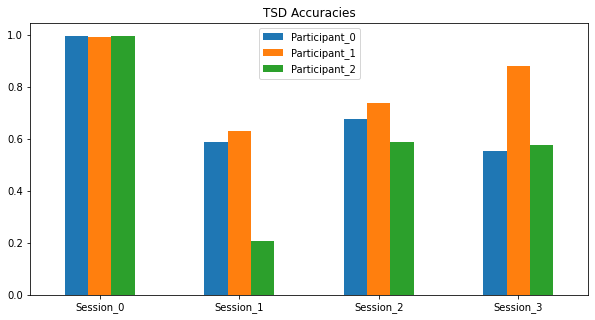

In [12]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_TSD.jpg")
plt.show()

# 2. Domain Adverserial Neural Network (DANN)
* 2 domians : source(0) and target(1) (output_domain includes 2 features)
    * source / validation: labeled; first training
    * target: unlabeled; others
    * train using one source and one target
* start training using TSD_DNN model params 
* DANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = crossEntropyLoss(pred_domain_source, label_source_domain)
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_domain_target = 0.5 * domain_loss_weight * loss_domain_target
    * loss_main = loss_main_source + loss_domain_target
    * loss_domain = loss_domain_source + loss_domain_target
   
### Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD
    * beat_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict     

In [13]:
from LongTermClassificationMain.TrainingsAndEvaluations.ForTrainingSessions.TSD_DNN.train_tsd_dnn_standard import \
    test_TSD_DNN_on_training_sessions
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_DA_spectrograms
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [14]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_DA import test_network_DA_algorithm

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [15]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [16]:
num_neurons = [200, 200, 200]
feature_vector_input_length = 385
gestures_to_remove = [5, 6, 9, 10]
gestures_to_remove = None
number_of_class = 11
number_of_cycle_for_first_training = 4
number_of_cycles_rest_of_training = 4
learning_rate = 0.002515

path_weights_fine_tuning = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "DANN_THREE_CYCLES_11Gestures_TSD"

In [17]:
train_DA_spectrograms(examples_datasets_train, labels_datasets_train, filter_size=None,
                      num_kernels=num_neurons, algo_name=algo_name,
                      path_weights_fine_tuning=path_weights_fine_tuning,
                      gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                      number_of_cycle_for_first_training=number_of_cycle_for_first_training,
                      number_of_cycles_rest_of_training=number_of_cycles_rest_of_training,
                      batch_size=128, spectrogram_model=False,
                      feature_vector_input_length=feature_vector_input_length,
                      path_weights_to_save_to="Weights_TSD/weights_", learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2674, 385)
(4,)   1
SHAPE X:  (2829, 385)
(4,)   2
SHAPE X:  (2881, 385)
(4,)   3
SHAPE X:  (2821, 385)
(4,)   0
SHAPE X:  (2970, 385)
(4,)   1
SHAPE X:  (2859, 385)
(4,)   2
SHAPE X:  (2837, 385)
(4,)   3
SHAPE X:  (2783, 385)
(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2888, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2835, 385)
SHAPE SESSIONS:  (4,)
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        

Accuracy source 0.969141, main loss classifier 0.139213, source classification loss 0.104336, loss domain distinction 0.652068, accuracy domain distinction 0.503320
VALIDATION Loss: 0.20247392 Acc: 0.92281879
Epoch 22 of 500 took 0.304s
Accuracy source 0.972656, main loss classifier 0.137415, source classification loss 0.101484, loss domain distinction 0.643768, accuracy domain distinction 0.502148
VALIDATION Loss: 0.22646032 Acc: 0.92281879
Epoch 23 of 500 took 0.294s
Accuracy source 0.975781, main loss classifier 0.130587, source classification loss 0.087984, loss domain distinction 0.642837, accuracy domain distinction 0.505273
VALIDATION Loss: 0.27631086 Acc: 0.89597315
Epoch    71: reducing learning rate of group 0 to 3.2192e-08.
Epoch 24 of 500 took 0.298s
Accuracy source 0.968359, main loss classifier 0.139767, source classification loss 0.104546, loss domain distinction 0.652416, accuracy domain distinction 0.488672
VALIDATION Loss: 0.16983737 Acc: 0.93624161
Epoch 25 of 500 to

Accuracy source 0.969141, main loss classifier 0.141107, source classification loss 0.107331, loss domain distinction 0.653614, accuracy domain distinction 0.509180
VALIDATION Loss: 0.33503160 Acc: 0.89261745
Epoch 16 of 500 took 0.298s
Accuracy source 0.969531, main loss classifier 0.139706, source classification loss 0.103662, loss domain distinction 0.658166, accuracy domain distinction 0.506836
VALIDATION Loss: 0.42384365 Acc: 0.8557047
Epoch 17 of 500 took 0.327s
Accuracy source 0.967969, main loss classifier 0.144959, source classification loss 0.112413, loss domain distinction 0.662997, accuracy domain distinction 0.496484
VALIDATION Loss: 0.38487995 Acc: 0.87583893
Epoch    65: reducing learning rate of group 0 to 1.6096e-07.
Epoch 18 of 500 took 0.343s
Accuracy source 0.969531, main loss classifier 0.139799, source classification loss 0.105095, loss domain distinction 0.654301, accuracy domain distinction 0.506055
VALIDATION Loss: 0.36968577 Acc: 0.88590604
Epoch 19 of 500 too

Accuracy source 0.971875, main loss classifier 0.138471, source classification loss 0.104008, loss domain distinction 0.640716, accuracy domain distinction 0.501172
VALIDATION Loss: 0.34384078 Acc: 0.88926174
Epoch 19 of 500 took 0.314s
Accuracy source 0.967187, main loss classifier 0.142113, source classification loss 0.109918, loss domain distinction 0.648226, accuracy domain distinction 0.500391
VALIDATION Loss: 0.22708240 Acc: 0.91275168
Epoch 20 of 500 took 0.303s
Accuracy source 0.970703, main loss classifier 0.139316, source classification loss 0.102724, loss domain distinction 0.654367, accuracy domain distinction 0.503906
VALIDATION Loss: 0.32220843 Acc: 0.88590604
Epoch 21 of 500 took 0.334s
Accuracy source 0.969922, main loss classifier 0.137974, source classification loss 0.099606, loss domain distinction 0.656373, accuracy domain distinction 0.504492
VALIDATION Loss: 0.36247462 Acc: 0.87248322
Epoch 22 of 500 took 0.344s
Accuracy source 0.974219, main loss classifier 0.135

Accuracy source 0.975852, main loss classifier 0.126366, source classification loss 0.081287, loss domain distinction 0.646589, accuracy domain distinction 0.513139
VALIDATION Loss: 0.06863474 Acc: 0.97575758
Epoch    50: reducing learning rate of group 0 to 1.6096e-07.
Epoch 18 of 500 took 0.320s
Accuracy source 0.976562, main loss classifier 0.127143, source classification loss 0.083834, loss domain distinction 0.640282, accuracy domain distinction 0.509233
VALIDATION Loss: 0.06273346 Acc: 0.97878788
Training complete in 0m 7s
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchN

Accuracy source 0.979167, main loss classifier 0.162088, source classification loss 0.077021, loss domain distinction 1.122644, accuracy domain distinction 0.505394
VALIDATION Loss: 0.04970623 Acc: 0.98484848
New best validation loss:  0.04970623180270195
Epoch 1 of 500 took 0.304s
Accuracy source 0.979911, main loss classifier 0.155087, source classification loss 0.075342, loss domain distinction 1.046892, accuracy domain distinction 0.498512
VALIDATION Loss: 0.04345572 Acc: 0.98787879
New best validation loss:  0.04345571994781494
Epoch 2 of 500 took 0.305s
Accuracy source 0.980655, main loss classifier 0.148402, source classification loss 0.073787, loss domain distinction 0.975607, accuracy domain distinction 0.495908
VALIDATION Loss: 0.05536653 Acc: 0.98787879
Epoch 3 of 500 took 0.300s
Accuracy source 0.975818, main loss classifier 0.141881, source classification loss 0.072699, loss domain distinction 0.900758, accuracy domain distinction 0.494234
VALIDATION Loss: 0.09094058 Acc: 

Accuracy source 0.979759, main loss classifier 0.106257, source classification loss 0.067337, loss domain distinction 0.272764, accuracy domain distinction 0.493253
VALIDATION Loss: 2.98801517 Acc: 0.50798722
New best validation loss:  2.9880151748657227
Epoch 1 of 500 took 0.321s
Accuracy source 0.984020, main loss classifier 0.106716, source classification loss 0.068240, loss domain distinction 0.195813, accuracy domain distinction 0.499822
VALIDATION Loss: 2.77549052 Acc: 0.54952077
New best validation loss:  2.7754905223846436
Epoch 2 of 500 took 0.340s
Accuracy source 0.985795, main loss classifier 0.098878, source classification loss 0.053945, loss domain distinction 0.190154, accuracy domain distinction 0.499290
VALIDATION Loss: 2.93719363 Acc: 0.55591054
Epoch 3 of 500 took 0.350s
Accuracy source 0.979048, main loss classifier 0.105448, source classification loss 0.069415, loss domain distinction 0.186744, accuracy domain distinction 0.500000
VALIDATION Loss: 3.14246702 Acc: 0.

Accuracy source 0.978693, main loss classifier 0.108701, source classification loss 0.070093, loss domain distinction 0.273780, accuracy domain distinction 0.491477
VALIDATION Loss: 0.17341076 Acc: 0.9456869
New best validation loss:  0.17341075837612152
Epoch 1 of 500 took 0.361s
Accuracy source 0.981534, main loss classifier 0.105488, source classification loss 0.065508, loss domain distinction 0.195572, accuracy domain distinction 0.499290
VALIDATION Loss: 0.07976484 Acc: 0.97444089
New best validation loss:  0.07976483553647995
Epoch 2 of 500 took 0.383s
Accuracy source 0.984375, main loss classifier 0.100113, source classification loss 0.057287, loss domain distinction 0.191037, accuracy domain distinction 0.499822
VALIDATION Loss: 0.23613723 Acc: 0.91054313
Epoch 3 of 500 took 0.362s
Accuracy source 0.979403, main loss classifier 0.108986, source classification loss 0.074569, loss domain distinction 0.188955, accuracy domain distinction 0.500178
VALIDATION Loss: 0.18132323 Acc: 0

Accuracy source 0.985440, main loss classifier 0.098145, source classification loss 0.057062, loss domain distinction 0.185794, accuracy domain distinction 0.500000
VALIDATION Loss: 0.19609575 Acc: 0.93290735
Epoch 11 of 500 took 0.420s
Accuracy source 0.985795, main loss classifier 0.097146, source classification loss 0.054114, loss domain distinction 0.187618, accuracy domain distinction 0.500000
VALIDATION Loss: 0.15331629 Acc: 0.94888179
Epoch    36: reducing learning rate of group 0 to 2.0120e-05.
Epoch 12 of 500 took 0.405s
Accuracy source 0.986861, main loss classifier 0.092451, source classification loss 0.047111, loss domain distinction 0.183759, accuracy domain distinction 0.500000
VALIDATION Loss: 0.20542796 Acc: 0.91373802
Epoch 13 of 500 took 0.379s
Accuracy source 0.987926, main loss classifier 0.095095, source classification loss 0.051744, loss domain distinction 0.184729, accuracy domain distinction 0.500000
VALIDATION Loss: 0.22987051 Acc: 0.92332268
Epoch 14 of 500 to

In [18]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)   
test_network_DA_algorithm(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_neurons, path_weights_DA='Weights_TSD/weights_' + algo_name,
                              algo_name=algo_name,
                              path_weights_normal=path_weights_fine_tuning,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                              cycle_to_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [19]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

DANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    DANN_acc[i] = acc
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
DANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.610619,0.776217,0.639657
Participant_1,0.994555,0.674858,0.726919,0.876228
Participant_2,0.996020,0.192344,0.840226,0.830206


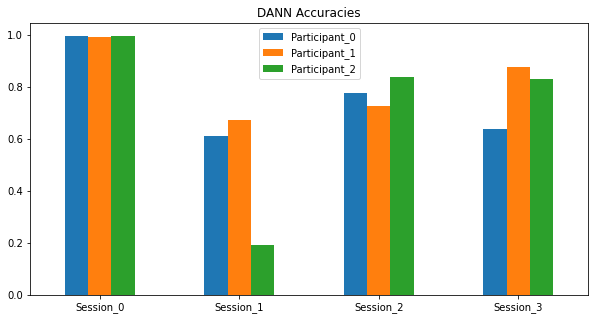

In [20]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_DANN.jpg")
plt.show()

# 3. SCADANN
* start training using TSD_DNN model params for the first training seesion, then using DANN model params 
* first traning = labeled, others = pseudo labels 
    * train using one lebaled and n psuedo labeled (n = #session)
* use all training data at once
* pseudo_labels_heuristic
    * window_stable_mode_length = 30 (hold stable for 1.5s)
    * percentage_same_gesture_now_stable = 65% (remove examples that are likely to generate false pseudo labels)
    * maximum_length_instability_gesture_transition = 40
    * maximum_length_instability_same_gesture = 40 (remove examples that are unstable for more than 2s)
* SCADANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = ((1 - alpha) * crossEntropyLoss(pred_domain_source, label_source_domain))
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_main_target = (0.5 * loss_target_class + domain_loss_weight * loss_domain_target)
    * loss_main = loss_main_source + loss_main_target
    * loss_domain = loss_domain_source + loss_domain_target

   

### Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN
* beat_state_n.pt (n = # training session)
    * epoch: #epochs
    * model state_dict
    * optimizer state_dict
    * scheduler state_dict     

In [21]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import load_checkpoint
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.load_dataset_spectrogram_in_dataloader import \
    load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.self_learning.self_learning_utils import \
    generate_dataloaders_for_SCADANN
from LongTermClassificationMain.Models.model_training_self_learning import SCADANN_BN_training


In [22]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from SCADANN_TSD_DNN_training_session import run_SCADANN_training_sessions, test_network_SLADANN
batch_size = 256

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [23]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)
examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [24]:
num_neurons = [200, 200, 200]
learning_rate = 0.002515
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11
percentage_same_gesture_stable = 0.65  # 0.65 for 11 gestures, 0.85 for 7 gestures
path_weight_to_save_to = "Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN"
path_weights_start_with = "Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD"
path_weights_Normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "SCADANN_THREE_CYCLES_11Gestures_TSD"

In [25]:
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_weight_to_save_to,
                              path_weights_Adversarial_training=path_weights_start_with,
                              path_weights_Normal_training=path_weights_Normal_training,
                              number_of_cycle_for_first_training=4, number_of_cycles_rest_of_training=4,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2972, 385)
(4,)   1
SHAPE X:  (3144, 385)
(4,)   2
SHAPE X:  (3202, 385)
(4,)   3
SHAPE X:  (3135, 385)
(4,)   0
SHAPE X:  (3300, 385)
(4,)   1
SHAPE X:  (3177, 385)
(4,)   2
SHAPE X:  (3153, 385)
(4,)   3
SHAPE X:  (3093, 385)
(4,)   0
SHAPE X:  (3129, 385)
(4,)   1
SHAPE X:  (3209, 385)
(4,)   2
SHAPE X:  (3183, 385)
(4,)   3
SHAPE X:  (3150, 385)
participants_train =  3
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (

BEFORE:  0.9042553191489362   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  1.0   AFTER:  1.0  len before:  95   len after:  95
BEFORE:  0.9175257731958762   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  90   len after:  90
BEFORE:  0.0   AFTER:  0.0  len before:  97   len after:  73
BEFORE:  0.5344827586206896   AFTER:  1.0  len before:  58   len after:  31
BEFORE:  0.3917525773195876   AFTER:  0.5555555555555556  len before:  97   len after:  72
BEFORE:  0.422680412371134   AFTER:  0.5416666666666666  len before:  97   len after:  72
BEFORE:  0.7731958762886598   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.1188118811881188   AFTER:  0.0  len before:  101   len after:  101
ACCURACY MODEL:  0.6288167938931297   Accuracy pseudo: 0.7611567297393788  len pseudo:  2801    len predictions 3144


/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


STARTING TRAINING
Accuracy total 0.836607, main loss classifier 0.768922, source accuracy 0.966518 source classification loss 0.108026, target accuracy 0.706696 target loss 1.202709 accuracy domain distinction 0.485268 loss domain distinction 1.135552,
VALIDATION Loss: 0.86712713 Acc: 0.78431373
New best validation loss:  0.8671271337403191
Epoch 2 of 500 took 0.568s
Accuracy total 0.837500, main loss classifier 0.788817, source accuracy 0.967411 source classification loss 0.123808, target accuracy 0.707589 target loss 1.228274 accuracy domain distinction 0.498437 loss domain distinction 1.127762,
VALIDATION Loss: 1.11972878 Acc: 0.73083779
Epoch 3 of 500 took 0.596s
Accuracy total 0.837500, main loss classifier 0.742731, source accuracy 0.963393 source classification loss 0.120618, target accuracy 0.711607 target loss 1.138710 accuracy domain distinction 0.494420 loss domain distinction 1.130671,
VALIDATION Loss: 0.96010715 Acc: 0.73796791
Epoch 4 of 500 took 0.654s
Accuracy total 0.8

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.6288659793814433   AFTER:  1.0  len before:  97   len after:  74
BEFORE:  0.5773195876288659   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9381443298969072   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.010309278350515464   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.5360824742268041   AFTER:  0.6804123711340206  len before:  97   len after:  97
BEFORE:  0.35051546391752575   AFTER:  nan  len before:  97   len after:  0
BEFORE:  0.6808510638297872   AFTER:  1.0  len before:  94   len after:  72
BEFORE:  0.5360824742268041   AFTER:  0.6701030927835051  len before:  97   len after:  97
BEFORE:  0.0   AFTER:  0.0  len before:  97   len after:  73
BEFORE:  0.8041237113402062   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9587628865979382

Accuracy total 0.864654, main loss classifier 0.591506, source accuracy 0.856419 source classification loss 0.503661, target accuracy 0.872889 target loss 0.461465 accuracy domain distinction 0.509291 loss domain distinction 1.089425,
VALIDATION Loss: 0.39564482 Acc: 0.90016639
Epoch    10: reducing learning rate of group 0 to 8.0480e-07.
Epoch 11 of 500 took 0.650s
Accuracy total 0.861698, main loss classifier 0.607588, source accuracy 0.850507 source classification loss 0.541351, target accuracy 0.872889 target loss 0.457540 accuracy domain distinction 0.509713 loss domain distinction 1.081426,
VALIDATION Loss: 0.40233786 Acc: 0.89184692
Epoch 12 of 500 took 0.649s
Accuracy total 0.855152, main loss classifier 0.643461, source accuracy 0.843328 source classification loss 0.586801, target accuracy 0.866976 target loss 0.476460 accuracy domain distinction 0.490921 loss domain distinction 1.118304,
VALIDATION Loss: 0.37360395 Acc: 0.89517471
Epoch 13 of 500 took 0.639s
Accuracy total 0.

BEFORE:  0.1188118811881188   AFTER:  0.0  len before:  101   len after:  101
ACCURACY MODEL:  0.6288167938931297   Accuracy pseudo: 0.7611567297393788  len pseudo:  2801    len predictions 3144
HANDLING NEW SESSION  2
Finish segment dataset
Finish pseudo_labels
BEFORE:  0.38144329896907214   AFTER:  1.0  len before:  97   len after:  32
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.061855670103092786   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9484536082474226   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  73
BEFORE:  0.9175257731958762   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.08247422680412371   AFTER

Accuracy total 0.817857, main loss classifier 0.824465, source accuracy 0.835714 source classification loss 0.629226, target accuracy 0.800000 target loss 0.796839 accuracy domain distinction 0.500670 loss domain distinction 1.114331,
VALIDATION Loss: 0.46177110 Acc: 0.85689046
Epoch 10 of 500 took 0.555s
Accuracy total 0.819420, main loss classifier 0.792281, source accuracy 0.839286 source classification loss 0.604950, target accuracy 0.799554 target loss 0.752930 accuracy domain distinction 0.497098 loss domain distinction 1.133409,
VALIDATION Loss: 0.48125322 Acc: 0.86219081
Epoch    10: reducing learning rate of group 0 to 1.6096e-07.
Epoch 11 of 500 took 0.538s
Accuracy total 0.814286, main loss classifier 0.820669, source accuracy 0.824107 source classification loss 0.663516, target accuracy 0.804464 target loss 0.752209 accuracy domain distinction 0.501786 loss domain distinction 1.128060,
VALIDATION Loss: 0.41442364 Acc: 0.89575972
New best validation loss:  0.4144236428870095

BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.8723404255319149   AFTER:  1.0  len before:  94   len after:  74
BEFORE:  0.711340206185567   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5257731958762887   AFTER:  1.0  len before:  97   len after:  72
BEFORE:  0.9072164948453608   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.24742268041237114   AFTER:  0.0  len before:  97   len after:  31
BEFORE:  0.9361702127659575   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7835051546391752   AFTER:  1.0  len before:  97   len after:  52
BEFORE:  0.3617021276595745   AFTER:  0.3723404255319149  len before:  94   len after:  94
BEFORE:  0.08247422680412371   AFTER:  0.0  len before:  97   len after:  69
ACCURACY MODEL:  0.6927919420837267   Accuracy pseudo: 0.8480631816472358  len pseudo:  2659    len predictions 3177
STARTING TRAINING
Accuracy total 0.871686, main loss classifi

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.44329896907216493   AFTER:  0.6907216494845361  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9381443298969072   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.3917525773195876   AFTER:  0.5277777777777778  len before:  97   len after:  72
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.4639175257731959   AFTER:  0.8461538461538461  len before:  97   len after:  13
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.4742268041237113   AFTER:  0.14814814814814814  len before:  97   len after:  54
BEFORE:  0.9081632653061225   AFTER:  1.0  len before:  98   len after:  71
BEFORE:  0.41237113402061853   AFTER:  0.6907216494845361  len before:  97   len after:  97
BEFORE:  0.9690721649484536   AFTER:  1.0  

Accuracy total 0.862723, main loss classifier 0.620558, source accuracy 0.879911 source classification loss 0.404550, target accuracy 0.845536 target loss 0.624689 accuracy domain distinction 0.500446 loss domain distinction 1.059388,
VALIDATION Loss: 0.32995538 Acc: 0.90053286
Epoch 19 of 500 took 0.474s
Accuracy total 0.871652, main loss classifier 0.600882, source accuracy 0.897321 source classification loss 0.361265, target accuracy 0.845982 target loss 0.628283 accuracy domain distinction 0.496205 loss domain distinction 1.061078,
VALIDATION Loss: 0.30226802 Acc: 0.90941385
New best validation loss:  0.30226801832516986
Epoch 20 of 500 took 0.474s
Accuracy total 0.865402, main loss classifier 0.632988, source accuracy 0.890179 source classification loss 0.391170, target accuracy 0.840625 target loss 0.664916 accuracy domain distinction 0.509152 loss domain distinction 1.049449,
VALIDATION Loss: 0.37034417 Acc: 0.88454707
Epoch 21 of 500 took 0.472s
Accuracy total 0.868080, main lo

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.44329896907216493   AFTER:  0.6907216494845361  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9381443298969072   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.3917525773195876   AFTER:  0.5277777777777778  len before:  97   len after:  72
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.4639175257731959   AFTER:  0.8461538461538461  len before:  97   len after:  13
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.4742268041237113   AFTER:  0.14814814814814814  len before:  97   len after:  54
BEFORE:  0.9081632653061225   AFTER:  1.0  len before:  98   len after:  71
BEFORE:  0.41237113402061853   AFTER:  0.6907216494845361  len before:  97   len after:  97
BEFORE:  0.9690721649484536   AFTER:  1.0  

Accuracy total 0.865017, main loss classifier 0.648527, source accuracy 0.867188 source classification loss 0.499595, target accuracy 0.862847 target loss 0.577387 accuracy domain distinction 0.500868 loss domain distinction 1.100357,
VALIDATION Loss: 0.46016553 Acc: 0.88435374
Epoch    10: reducing learning rate of group 0 to 1.6096e-07.
Epoch 11 of 500 took 0.489s
Accuracy total 0.862847, main loss classifier 0.651229, source accuracy 0.865451 source classification loss 0.512167, target accuracy 0.860243 target loss 0.570525 accuracy domain distinction 0.495660 loss domain distinction 1.098829,
VALIDATION Loss: 0.52445634 Acc: 0.9047619
Epoch 12 of 500 took 0.488s
Accuracy total 0.858941, main loss classifier 0.652234, source accuracy 0.857205 source classification loss 0.529516, target accuracy 0.860677 target loss 0.555869 accuracy domain distinction 0.500651 loss domain distinction 1.095419,
VALIDATION Loss: 0.39223663 Acc: 0.92176871
New best validation loss:  0.39223663192242386

BEFORE:  0.7525773195876289   AFTER:  0.5733333333333334  len before:  97   len after:  75
BEFORE:  0.020618556701030927   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.23711340206185566   AFTER:  0.0  len before:  97   len after:  38
BEFORE:  0.0594059405940594   AFTER:  0.0  len before:  101   len after:  31
ACCURACY MODEL:  0.213773761296354   Accuracy pseudo: 0.25667090216010163  len pseudo:  2361    len predictions 3209
STARTING TRAINING
Accuracy total 0.800108, main loss classifier 0.987748, source accuracy 0.979526 source classification loss 0.071321, target accuracy 0.620690 target loss 1.658067 accuracy domain distinction 0.500000 loss domain distinction 1.230534,
VALIDATION Loss: 0.96597153 Acc: 0.7589852
New best validation loss:  0.9659715294837952
Epoch 2 of 500 took 0.398s
Accuracy total 0.826778, main loss classifier 0.848037, source accuracy 0.977909 source classification loss 0.069592, target accuracy 0.675647 target loss 1.390346 accuracy domain distinction

Accuracy total 0.881466, main loss classifier 0.535339, source accuracy 0.975754 source classification loss 0.078146, target accuracy 0.787177 target loss 0.780749 accuracy domain distinction 0.500539 loss domain distinction 1.058923,
VALIDATION Loss: 0.50389491 Acc: 0.86046512
Epoch 26 of 500 took 0.429s
Accuracy total 0.881735, main loss classifier 0.516838, source accuracy 0.982220 source classification loss 0.063399, target accuracy 0.781250 target loss 0.760041 accuracy domain distinction 0.500269 loss domain distinction 1.051181,
VALIDATION Loss: 0.49842641 Acc: 0.86257928
New best validation loss:  0.4984264075756073
Epoch 27 of 500 took 0.457s
Accuracy total 0.868804, main loss classifier 0.581507, source accuracy 0.966056 source classification loss 0.097124, target accuracy 0.771552 target loss 0.853377 accuracy domain distinction 0.500539 loss domain distinction 1.062568,
VALIDATION Loss: 0.58588985 Acc: 0.80549683
Epoch 28 of 500 took 0.505s
Accuracy total 0.874192, main los

BEFORE:  0.030927835051546393   AFTER:  0.0  len before:  97   len after:  74
BEFORE:  0.07216494845360824   AFTER:  0.0  len before:  97   len after:  45
BEFORE:  0.7525773195876289   AFTER:  0.5733333333333334  len before:  97   len after:  75
BEFORE:  0.020618556701030927   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.23711340206185566   AFTER:  0.0  len before:  97   len after:  38
BEFORE:  0.0594059405940594   AFTER:  0.0  len before:  101   len after:  31
ACCURACY MODEL:  0.213773761296354   Accuracy pseudo: 0.25667090216010163  len pseudo:  2361    len predictions 3209
HANDLING NEW SESSION  2
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9381443298969072   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.979381443298969   AFTER:  1.0  len be

Accuracy total 0.922297, main loss classifier 0.342564, source accuracy 0.911318 source classification loss 0.269100, target accuracy 0.933277 target loss 0.209391 accuracy domain distinction 0.500000 loss domain distinction 1.033179,
VALIDATION Loss: 0.11294012 Acc: 0.95709571
Epoch 18 of 500 took 0.525s
Accuracy total 0.926731, main loss classifier 0.339640, source accuracy 0.919341 source classification loss 0.255836, target accuracy 0.934122 target loss 0.216138 accuracy domain distinction 0.500000 loss domain distinction 1.036534,
VALIDATION Loss: 0.09483541 Acc: 0.9620462
New best validation loss:  0.09483541250228882
Epoch 19 of 500 took 0.577s
Accuracy total 0.935389, main loss classifier 0.329372, source accuracy 0.926520 source classification loss 0.245480, target accuracy 0.944257 target loss 0.205858 accuracy domain distinction 0.500000 loss domain distinction 1.037026,
VALIDATION Loss: 0.08566367 Acc: 0.97359736
New best validation loss:  0.08566367216408252
Epoch 20 of 50

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9381443298969072   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7422680412371134   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5567010309278351   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.8969072164948454   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.851063829787234   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.8556701030927835   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5463917525773195   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9484

Accuracy total 0.890402, main loss classifier 0.466325, source accuracy 0.892411 source classification loss 0.367020, target accuracy 0.888393 target loss 0.356928 accuracy domain distinction 0.500000 loss domain distinction 1.043503,
VALIDATION Loss: 0.40424802 Acc: 0.86561955
Epoch 11 of 500 took 0.491s
Accuracy total 0.892857, main loss classifier 0.449472, source accuracy 0.897768 source classification loss 0.341032, target accuracy 0.887946 target loss 0.348079 accuracy domain distinction 0.500000 loss domain distinction 1.049170,
VALIDATION Loss: 0.32379214 Acc: 0.88830716
Epoch 12 of 500 took 0.476s
Accuracy total 0.894643, main loss classifier 0.443374, source accuracy 0.892411 source classification loss 0.360388, target accuracy 0.896875 target loss 0.317987 accuracy domain distinction 0.500000 loss domain distinction 1.041862,
VALIDATION Loss: 0.70836873 Acc: 0.79406632
Epoch    12: reducing learning rate of group 0 to 1.0060e-04.
Epoch 13 of 500 took 0.471s
Accuracy total 0.

In [26]:
path_weights_normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                     path_weights_ASR=path_weight_to_save_to, path_weights_normal=path_weights_normal_training,
                     algo_name=algo_name, cycle_test=3, gestures_to_remove=gestures_to_remove,
                     number_of_classes=number_of_classes)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [27]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

SCADANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    SCADANN_acc[i] = acc
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
SCADANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.575221,0.793071,0.626311
Participant_1,0.994555,0.689981,0.724004,0.888016
Participant_2,0.996020,0.152194,0.947368,0.958724


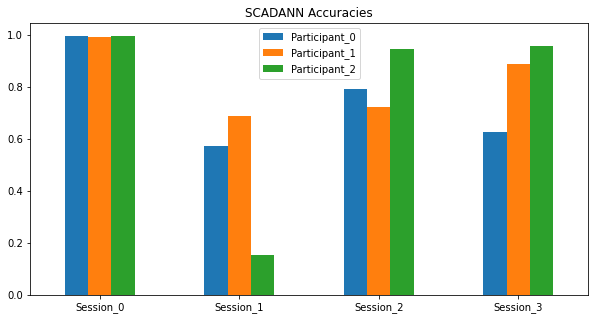

In [28]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_SCADANN.jpg")
plt.show()

# Conclusion

In [29]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.702829
DANN,0.762908
SCADANN,0.778542


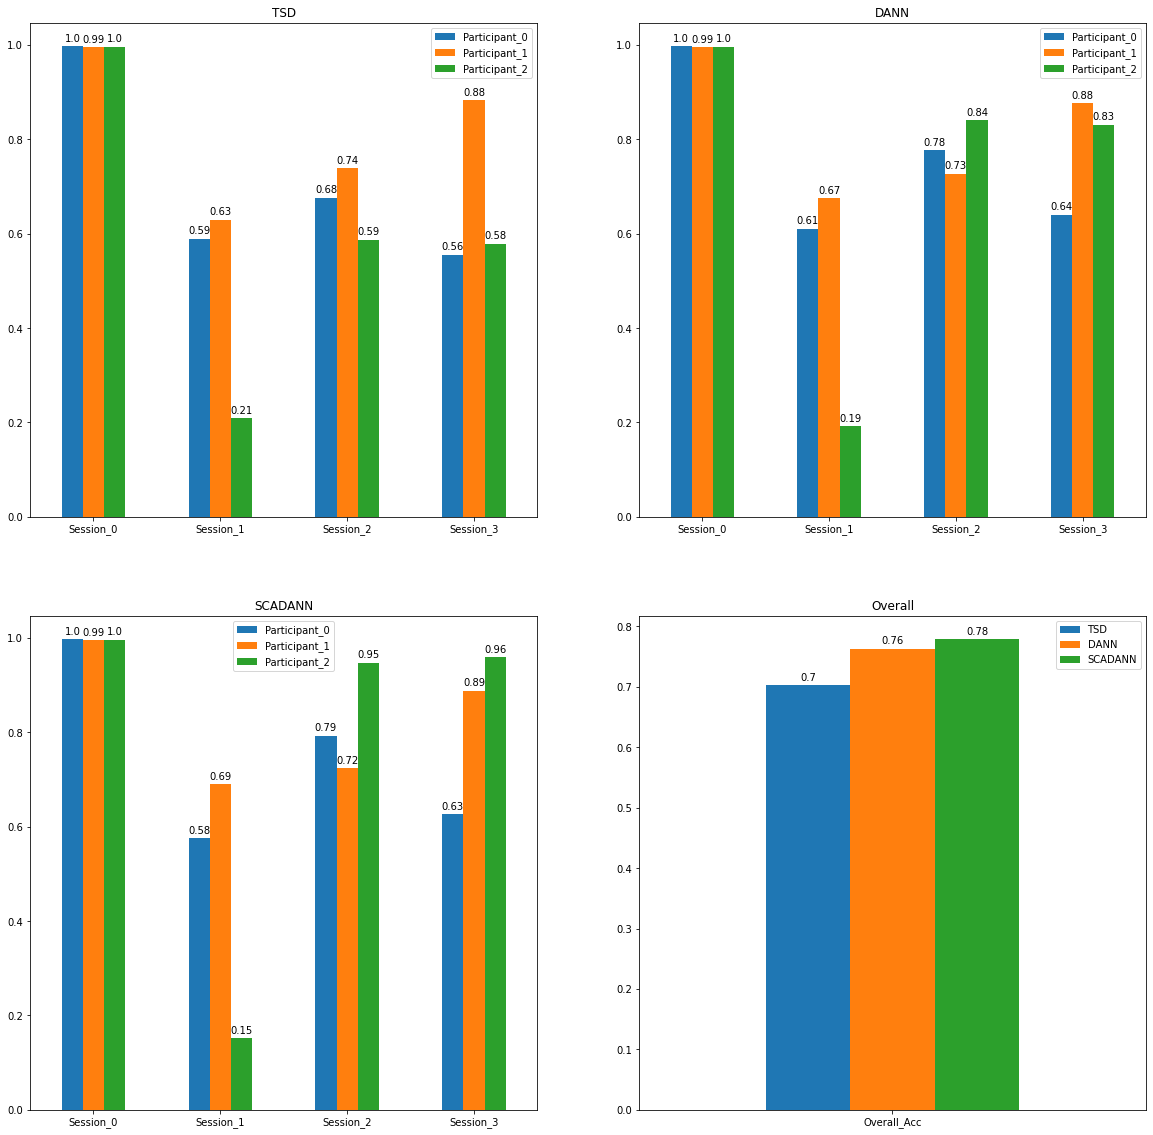

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')
fig.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_results.jpg")


Note for 2_only dataset:   
* result from STD -> DANN -> SCADANN  
    * 10.0 -> 17.9 -> 16.0
    * 17.2 -> 17.9 -> 16.9
    * 14.3 -> 16.5 -> 14.6
    * 12.7 -> 19.0 -> 16.4
* maybe this is just a bad data  
* percentage_same_gesture_stable=0.65
    * maybe too many unstable examples 